In [1]:
# Data handling and computation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE

# Model selection and validation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression

# Pipeline library for efficient workflow
from sklearn.pipeline import Pipeline, make_pipeline

# Metrics libraries for evaluating model performance
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, roc_curve, auc, accuracy_score, confusion_matrix
from sklearn import metrics

# Natural Language Toolkit
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re


In [2]:
# Read in data locally
#df = pd.read_csv('data/Tweets.csv', encoding='latin1')

# Read in data using google colab/drive
df = pd.read_csv('/content/drive/MyDrive/Flatiron/project_4/tweets.csv', encoding='latin1')

In [35]:
numerical_features = list(df.select_dtypes("number"))
categorical_features = list(df.select_dtypes("object"))

print(f'Numerical Columns: \n{numerical_features}\n')
print(f'Categorical Columns: \n{categorical_features}')

Numerical Columns: 
['character_count', 'word_count', 'is_tweet_negative', 'is_apple', 'number_of_mentions', 'hashtags_count', 'average_word_length', 'chatgpt_data']

Categorical Columns: 
['tweet', 'tweet_is_directed_at', 'emotion', 'processed_tweet']


## EDA

In [19]:
df.head()

,tweet,tweet_is_directed_at,emotion,character_count,word_count,is_tweet_negative,is_apple,number_of_mentions,hashtags_count,average_word_length,chatgpt_data
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,iphone,negative,127,23,1,1,1,2,4.521739,0
1,@jessedee know about @fludapp ? awesome ipad/i...,ipad or iphone app,positive,139,22,0,1,2,1,5.363636,0
2,@swonderlin can not wait for #ipad 2 also. the...,ipad,positive,79,15,0,1,1,2,4.333333,0
3,@sxsw i hope this year's festival isn't as cra...,ipad or iphone app,negative,82,15,1,1,1,1,4.533333,0
4,@sxtxstate great stuff on fri #sxsw: marissa m...,google,positive,131,17,0,0,1,1,6.764706,0


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8369 entries, 0 to 9092
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   tweet                 8369 non-null   object 
 1   tweet_is_directed_at  3291 non-null   object 
 2   emotion               8369 non-null   object 
 3   character_count       8369 non-null   int64  
 4   word_count            8369 non-null   int64  
 5   is_tweet_negative     8369 non-null   int64  
 6   is_apple              8369 non-null   Int64  
 7   number_of_mentions    8369 non-null   int64  
 8   hashtags_count        8369 non-null   int64  
 9   average_word_length   8369 non-null   float64
 10  processed_tweet       8369 non-null   object 
dtypes: Int64(1), float64(1), int64(5), object(4)
memory usage: 792.8+ KB


In [27]:
df.nunique().sort_values(ascending=True)

is_apple                   2
is_tweet_negative          3
emotion                    4
tweet_is_directed_at       9
number_of_mentions         9
hashtags_count            13
word_count                30
character_count          143
average_word_length      785
processed_tweet         8218
tweet                   8326
dtype: int64

In [28]:
df.isna().sum().sort_values(ascending=False)

tweet_is_directed_at    5078
tweet                      0
emotion                    0
character_count            0
word_count                 0
is_tweet_negative          0
is_apple                   0
number_of_mentions         0
hashtags_count             0
average_word_length        0
processed_tweet            0
dtype: int64

In [29]:
df.corr()

<ipython-input-29-2f6f6606aa2c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,character_count,word_count,is_tweet_negative,is_apple,number_of_mentions,hashtags_count,average_word_length
character_count,1.000000,0.895978,-0.027270,-0.039956,0.280058,0.077787,0.083888
word_count,0.895978,1.000000,-0.065890,0.101657,0.205961,-0.033520,-0.345719
is_tweet_negative,-0.027270,-0.065890,1.000000,-0.098725,0.019582,0.039116,0.091686
is_apple,-0.039956,0.101657,-0.098725,1.000000,-0.036238,0.037333,-0.295527
number_of_mentions,0.280058,0.205961,0.019582,-0.036238,1.000000,-0.020735,0.100823
hashtags_count,0.077787,-0.033520,0.039116,0.037333,-0.020735,1.000000,0.237964
average_word_length,0.083888,-0.345719,0.091686,-0.295527,0.100823,0.237964,1.000000



## Data Cleaning

In [4]:
# Lowercase
df = df.applymap(lambda s:s.lower() if type(s) == str else s)

# Renaming columns to better reflect the data
rename_cols = {
      'tweet_text': 'tweet',
      'emotion_in_tweet_is_directed_at': 'tweet_is_directed_at',
      'is_there_an_emotion_directed_at_a_brand_or_product': 'emotion'
              }
df = df.rename(columns=rename_cols)


# rename values in the 'emotion' column
rename_values = {
      'no emotion toward brand or product': 'no emotion',
      'positive emotion': 'positive',
      'negative emotion': 'negative',
      "i can't tell": 'unsure'
              }
df['emotion'] = df['emotion'].map(rename_values)


# Dropping (1) single row from df['tweet_text']
df.dropna(subset='tweet', inplace=True)


# Filter out 17 tweets that contain both Apple & Google
apple_and_google = ~((df['tweet_is_directed_at'].isna()) &
                   (df['tweet'].str.contains('google')) &
                   (df['tweet'].str.contains('apple')))
df = df[apple_and_google]



## Create assert statements to confirm the code achieved its goals:

assert df.loc[(df['tweet_is_directed_at'].isna()) & (df['tweet'].str.contains('google')) & (df['tweet'].str.contains('apple')), 'tweet'].empty


## Feature Engineering

In [18]:
# Create column of with the character length of the tweet
df['character_count'] = df['tweet'].apply(len)


# Create column of with the word count of the tweet
df['word_count'] = df['tweet'].apply(lambda x: len(str(x).split()))


# Creat column to determine if the tweet was negative toward a brand or not
df['is_tweet_negative'] = df['emotion'].apply(lambda x: 1 if x == 'negative' else 0 if x == 'positive' else 2)

# What company is the tweet about?
renamed_values = {
      'ipad': 1, 'ipad or iphone app': 1,
      'iphone': 1, 'other google product or service': 0,
      'android app': 0, 'android': 0, 'google': 0,
      'other apple product or service': 1, 'apple': 1,
                 }
df['is_apple'] = df['tweet_is_directed_at'].map(renamed_values).astype('Int64')


# Creating a feature call 'number_of_mentions' to count @mentions
df['number_of_mentions'] = df['tweet'].str.count('@\w+')


# Create a feature 'hashtags_count' to count hashtags
df['hashtags_count'] = df['tweet'].str.count('#')


# Create feature named 'average_word_length'
df['average_word_length'] = df['tweet'].apply(lambda x: np.mean([len(word) for word in x.split()]))

# Adding column to tell if data was generated by chatgpt data
df['chatgpt_data'] = 0


## Data Filtering

In [6]:
# Assigning unknown tweet to company based on 'apple_words'
apple_words = ['apple', 'iphone','ipod','ipad', 'i-pad', 'app store', 'itunes']
apple_regex = '|'.join(apple_words)  # creates the string 'apple|iphone|ipod|ipad|i-pad'

df.loc[(df['is_apple'].isna()) & df['tweet'].str.contains(apple_regex, case=False), 'is_apple'] = 1


# Assigning unknown tweet to company based on 'google_words'
google_words = ['google', 'android','pixel', 'google play']
google_regex = '|'.join(google_words)  # creates the string 'google|android|pixel|google play'

df.loc[(df['is_apple'].isna()) & df['tweet'].str.contains(google_regex, case=False), 'is_apple'] = 0


# Dropping tweets that have no mention of either Apple or Google
df.dropna(subset=['is_apple'], inplace=True)


# Drop the column 'tweet_is_directed_at' due to many missing values
#df = df.drop(columns=['tweet_is_directed_at'])

In [7]:
df['is_apple'].value_counts()

1    5567
0    2802
Name: is_apple, dtype: Int64

In [8]:
df['is_tweet_negative'].value_counts()

2    4833
0    2967
1     569
Name: is_tweet_negative, dtype: int64

## Import and Join Negative Tweet Data (via ChatGPT prompt engineering)

In [9]:
df['is_tweet_negative'].value_counts()

2    4833
0    2967
1     569
Name: is_tweet_negative, dtype: int64

In [21]:
# Read in data locally
#neg_tweets = pd.read_csv('data/chatgpt_tweet_data.csv')

# Read in data using google colab/drive
neg_tweets = pd.read_csv('/content/drive/MyDrive/Flatiron/project_4/chatgpt_tweet_data.csv')

# Lowercase
neg_tweets = neg_tweets.applymap(lambda s:s.lower() if type(s) == str else s)

# Adding column to tell if data was generated by chatgpt data
neg_tweets['chatgpt_data'] = 1

In [22]:
neg_tweets.head()

,tweet,tweet_is_directed_at,emotion,character_count,word_count,is_tweet_negative,is_apple,number_of_mentions,hashtags_count,average_word_length,chatgpt_data
0,can't believe how slow the new iphone is!,apple,negative,37,8,1,1,0,0,4.6,1
1,google search results are so frustrating!,google,negative,37,6,1,0,0,0,6.2,1
2,the latest apple update crashed my device again!,apple,negative,45,9,1,1,0,0,4.8,1
3,i'm so disappointed with google's new feature.,google,negative,40,8,1,0,0,0,5.0,1
4,apple's customer service is a nightmare!,apple,negative,38,7,1,1,0,0,5.4,1


In [23]:
#Join Dataframes
df = pd.concat([df, neg_tweets])

In [26]:
df['is_tweet_negative'].value_counts()

2    4833
0    2967
1    2920
Name: is_tweet_negative, dtype: int64

## Modeling

In [27]:
# You might need to download these if you haven't already
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [28]:
# Function to preprocess tweets
def preprocess(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r'[^\w\s@#]', ' ', tweet)
    tweet = re.sub(r'\s+[a-zA-Z]\s+', ' ', tweet)
    tweet = re.sub(r'\s+', ' ', tweet, flags=re.I)
    tweet = re.sub(r'^b\s+', '', tweet)
    tweet = tweet.split()
    tweet = [lemmatizer.lemmatize(word) for word in tweet if not word in stop_words]
    tweet = ' '.join(tweet)
    return tweet



In [29]:
# Apply preprocessing function to tweets
df['processed_tweet'] = df['tweet'].apply(preprocess)

In [30]:
# Feature extraction with TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['processed_tweet']).toarray()
y = df['is_tweet_negative']

In [31]:
# Split data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [32]:
# Print the original class distribution
print('Original class distribution: \n', y_train.value_counts())

Original class distribution: 
 2    3867
0    2379
1    2330
Name: is_tweet_negative, dtype: int64


In [33]:
# Train the model
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Make predictions
y_pred = classifier.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.43      0.49       588
           1       0.94      0.81      0.87       590
           2       0.66      0.82      0.73       966

    accuracy                           0.71      2144
   macro avg       0.73      0.69      0.70      2144
weighted avg       0.72      0.71      0.71      2144

Accuracy: 0.7112873134328358


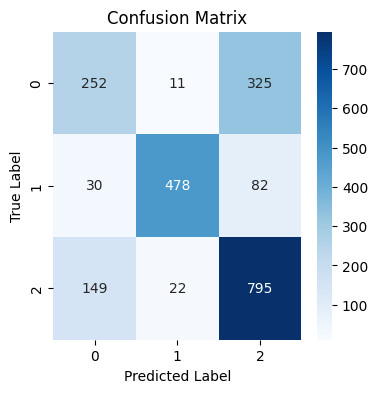

              precision    recall  f1-score   support

           0       0.58      0.43      0.49       588
           1       0.94      0.81      0.87       590
           2       0.66      0.82      0.73       966

    accuracy                           0.71      2144
   macro avg       0.73      0.69      0.70      2144
weighted avg       0.72      0.71      0.71      2144

Accuracy: 0.7112873134328358


In [34]:
# Generate confusion matrix
matrix = confusion_matrix(y_test, y_pred)

# Create a heatmap from the confusion matrix
plt.figure(figsize=(4,4))
sns.heatmap(matrix, annot=True, cmap='Blues', fmt='d')

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.show()

# Evaluate the model
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))